# MSG-Net training

Based on: https://github.com/zhanghang1989/PyTorch-Multi-Style-Transfer

Dataset: https://cocodataset.org/#download
    
    Train - http://images.cocodataset.org/zips/train2014.zip

In [ ]:
# Mount Google Drive for saving intermediate steps and trained model
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp -r "drive/MyDrive/msgnet/images/" "images/"

In [ ]:
# Download dataset
# !wget -P "//" "http://images.cocodataset.org/zips/train2014.zip"

In [ ]:
# !cp "/dataset/train2014.zip" "drive/MyDrive/msgnet/dataset/"

In [ ]:
%mkdir 'dataset/'
!unzip "/content/drive/MyDrive/msgnet/dataset/small_train.zip" -d "/dataset/"

In [ ]:
%mkdir "/content/drive/MyDrive/msgnet/models/"

In [ ]:
import os
import sys
import time
import numpy as np
from tqdm import tqdm, trange

import torch
from torch.optim import Adam
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

import torchvision
from torchvision import datasets
from torchvision import transforms

from PIL import Image


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cpu


In [ ]:
# import numpy & pytorch
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable


# define Gram Matrix
class GramMatrix(nn.Module):
    def forward(self, y):
        (b, ch, h, w) = y.size()
        features = y.view(b, ch, w * h)
        features_t = features.transpose(1, 2)
        gram = features.bmm(features_t) / (ch * h * w)
        return gram


# proposed Inspiration(CoMatch) Layer
class Inspiration(nn.Module):
    """ Inspiration Layer (from MSG-Net paper)
    tuning the featuremap with target Gram Matrix
    ref https://arxiv.org/abs/1703.06953
    """
    def __init__(self, C, B=1):
        super(Inspiration, self).__init__()
        # B is equal to 1 or input mini_batch
        self.weight = nn.Parameter(torch.Tensor(1, C, C), requires_grad=True)
        # non-parameter buffer
        self.G = Variable(torch.Tensor(B, C, C), requires_grad=True)
        self.C = C
        self.reset_parameters()

    def reset_parameters(self):
        self.weight.data.uniform_(0.0, 0.02)

    def setTarget(self, target):
        self.G = target

    def forward(self, X):
        # input X is a 3D feature map
        self.P = torch.bmm(self.weight.expand_as(self.G), self.G)
        return torch.bmm(self.P.transpose(1, 2).expand(X.size(0), self.C, self.C),
                         X.view(X.size(0), X.size(1), -1)).view_as(X)

    def __repr__(self):
        return self.__class__.__name__ + '(' + 'N x ' + str(self.C) + ')'


# some basic layers, with reflectance padding
class ConvLayer(torch.nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride):
        super(ConvLayer, self).__init__()
        reflection_padding = kernel_size // 2
        self.reflection_pad = nn.ReflectionPad2d(reflection_padding)
        self.conv2d = nn.Conv2d(in_channels, out_channels, kernel_size, stride)

    def forward(self, x):
        out = self.reflection_pad(x)
        out = self.conv2d(out)
        return out


class UpsampleConvLayer(torch.nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride,
                 upsample=None):
        super(UpsampleConvLayer, self).__init__()
        self.upsample = upsample
        if upsample:
            self.upsample_layer = torch.nn.Upsample(scale_factor=upsample)
        self.reflection_padding = kernel_size // 2
        if self.reflection_padding != 0:
            self.reflection_pad = nn.ReflectionPad2d(self.reflection_padding)
        self.conv2d = nn.Conv2d(in_channels, out_channels, kernel_size, stride)

    def forward(self, x):
        if self.upsample:
            x = self.upsample_layer(x)
        if self.reflection_padding != 0:
            x = self.reflection_pad(x)
        out = self.conv2d(x)
        return out


class Bottleneck(nn.Module):
    """ Pre-activation residual block
    Identity Mapping in Deep Residual Networks
    ref https://arxiv.org/abs/1603.05027
    """
    def __init__(self, inplanes, planes, stride=1, downsample=None,
                 norm_layer=nn.BatchNorm2d):
        super(Bottleneck, self).__init__()
        self.expansion = 4
        self.downsample = downsample
        if self.downsample is not None:
            self.residual_layer = nn.Conv2d(inplanes, planes*self.expansion,
                                            kernel_size=1, stride=stride)
        conv_block = []
        conv_block += [norm_layer(inplanes),
                       nn.ReLU(inplace=True),
                       nn.Conv2d(inplanes, planes, kernel_size=1, stride=1)]
        conv_block += [norm_layer(planes),
                       nn.ReLU(inplace=True),
                       ConvLayer(planes, planes, kernel_size=3, stride=stride)]
        conv_block += [norm_layer(planes),
                       nn.ReLU(inplace=True),
                       nn.Conv2d(planes, planes*self.expansion, kernel_size=1,
                                 stride=1)]
        self.conv_block = nn.Sequential(*conv_block)

    def forward(self, x):
        if self.downsample is not None:
            residual = self.residual_layer(x)
        else:
            residual = x
        return residual + self.conv_block(x)


class UpBottleneck(nn.Module):
    """ Up-sample residual block (from MSG-Net paper)
    Enables passing identity all the way through the generator
    ref https://arxiv.org/abs/1703.06953
    """
    def __init__(self, inplanes, planes, stride=2, norm_layer=nn.BatchNorm2d):
        super(UpBottleneck, self).__init__()
        self.expansion = 4
        self.residual_layer = UpsampleConvLayer(inplanes, planes*self.expansion,
                                                kernel_size=1, stride=1,
                                                upsample=stride)
        conv_block = []
        conv_block += [norm_layer(inplanes),
                       nn.ReLU(inplace=True),
                       nn.Conv2d(inplanes, planes, kernel_size=1, stride=1)]
        conv_block += [norm_layer(planes),
                       nn.ReLU(inplace=True),
                       UpsampleConvLayer(planes, planes, kernel_size=3,
                                         stride=1, upsample=stride)]
        conv_block += [norm_layer(planes),
                       nn.ReLU(inplace=True),
                       nn.Conv2d(planes, planes*self.expansion, kernel_size=1,
                                 stride=1)]
        self.conv_block = nn.Sequential(*conv_block)

    def forward(self, x):
        return self.residual_layer(x) + self.conv_block(x)


class Vgg16(torch.nn.Module):
    def __init__(self):
        super(Vgg16, self).__init__()
        self.conv1_1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.conv1_2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)

        self.conv2_1 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)

        self.conv3_1 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.conv3_3 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)

        self.conv4_1 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1)
        self.conv4_2 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)
        self.conv4_3 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)

        self.conv5_1 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)
        self.conv5_2 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)
        self.conv5_3 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)

    def forward(self, X):
        h = F.relu(self.conv1_1(X))
        h = F.relu(self.conv1_2(h))
        relu1_2 = h
        h = F.max_pool2d(h, kernel_size=2, stride=2)

        h = F.relu(self.conv2_1(h))
        h = F.relu(self.conv2_2(h))
        relu2_2 = h
        h = F.max_pool2d(h, kernel_size=2, stride=2)

        h = F.relu(self.conv3_1(h))
        h = F.relu(self.conv3_2(h))
        h = F.relu(self.conv3_3(h))
        relu3_3 = h
        h = F.max_pool2d(h, kernel_size=2, stride=2)

        h = F.relu(self.conv4_1(h))
        h = F.relu(self.conv4_2(h))
        h = F.relu(self.conv4_3(h))
        relu4_3 = h

        return [relu1_2, relu2_2, relu3_3, relu4_3]


# the MSG-Net
class Net(nn.Module):
    def __init__(self, input_nc=3, output_nc=3, ngf=64,
                 norm_layer=nn.InstanceNorm2d, n_blocks=6, gpu_ids=[]):
        super(Net, self).__init__()
        self.gpu_ids = gpu_ids
        self.gram = GramMatrix()

        block = Bottleneck
        upblock = UpBottleneck
        expansion = 4

        model1 = []
        model1 += [ConvLayer(input_nc, 64, kernel_size=7, stride=1),
                   norm_layer(64),
                   nn.ReLU(inplace=True),
                   block(64, 32, 2, 1, norm_layer),
                   block(32*expansion, ngf, 2, 1, norm_layer)]
        self.model1 = nn.Sequential(*model1)

        model = []
        self.ins = Inspiration(ngf*expansion)
        model += [self.model1]
        model += [self.ins]

        for i in range(n_blocks):
            model += [block(ngf*expansion, ngf, 1, None, norm_layer)]

        model += [upblock(ngf*expansion, 32, 2, norm_layer),
                  upblock(32*expansion, 16, 2, norm_layer),
                  norm_layer(16*expansion),
                  nn.ReLU(inplace=True),
                  ConvLayer(16*expansion, output_nc, kernel_size=7, stride=1)]

        self.model = nn.Sequential(*model)

    def setTarget(self, Xs):
        f = self.model1(Xs)
        G = self.gram(f)
        self.ins.setTarget(G)

    def forward(self, input):
        return self.model(input)

In [ ]:
from PIL import Image


def tensor_load_rgbimage(filename, size=None, scale=None, keep_asp=False):
    img = Image.open(filename).convert('RGB')
    if size is not None:
        if keep_asp:
            size2 = int(size * 1.0 / img.size[0] * img.size[1])
            img = img.resize((size, size2), Image.ANTIALIAS)
        else:
            img = img.resize((size, size), Image.ANTIALIAS)

    elif scale is not None:
        img = img.resize((int(img.size[0] / scale), int(img.size[1] / scale)),
                         Image.ANTIALIAS)
    img = np.array(img).transpose(2, 0, 1)
    img = torch.from_numpy(img).float()
    return img


def tensor_save_rgbimage(tensor, filename, cuda=False):
    if cuda:
        img = tensor.clone().cpu().clamp(0, 255).numpy()
    else:
        img = tensor.clone().clamp(0, 255).numpy()
    img = img.transpose(1, 2, 0).astype('uint8')
    img = Image.fromarray(img)
    img.save(filename)


def tensor_save_bgrimage(tensor, filename, cuda=False):
    (b, g, r) = torch.chunk(tensor, 3)
    tensor = torch.cat((r, g, b))
    tensor_save_rgbimage(tensor, filename, cuda)


def preprocess_batch(batch):
    batch = batch.transpose(0, 1)
    (r, g, b) = torch.chunk(batch, 3)
    batch = torch.cat((b, g, r))
    batch = batch.transpose(0, 1)
    return batch

In [ ]:
def init_vgg16(vgg16):
    torch_vgg16 = torchvision.models.vgg16( \
        weights=torchvision.models.VGG16_Weights.IMAGENET1K_FEATURES).features
    vgg16_list = list(vgg16.children())
    torch_vgg16_list = [x for x in list(vgg16.children()) if isinstance(x, nn.Conv2d)]

    for v, t in zip(vgg16_list, torch_vgg16_list):
        v.load_state_dict(t.state_dict())


class StyleLoader():
    def __init__(self, style_folder, style_size):
        self.folder = style_folder
        self.style_size = style_size
        self.files = os.listdir(style_folder)
    
    def get(self, i):
        idx = i%len(self.files)
        filepath = os.path.join(self.folder, self.files[idx])
        style = tensor_load_rgbimage(filepath, self.style_size)    
        style = style.unsqueeze(0)
        style = preprocess_batch(style)
        style = style.to(device)
        style_v = Variable(style, requires_grad=False)
        return style_v

    def size(self):
        return len(self.files)

In [ ]:
def gram_matrix(y):
    (b, ch, h, w) = y.size()
    features = y.view(b, ch, w * h)
    features_t = features.transpose(1, 2)
    gram = features.bmm(features_t) / (ch * h * w)
    return gram


def subtract_imagenet_mean_batch(batch):
    """Subtract ImageNet mean pixel-wise from a BGR image."""
    tensortype = type(batch.data)
    mean = tensortype(batch.data.size()).to(device)
    mean[:, 0, :, :] = 103.939
    mean[:, 1, :, :] = 116.779
    mean[:, 2, :, :] = 123.680
    return batch - Variable(mean)


def add_imagenet_mean_batch(batch):
    """Add ImageNet mean pixel-wise from a BGR image."""
    tensortype = type(batch.data)
    mean = tensortype(batch.data.size()).to(device)
    mean[:, 0, :, :] = 103.939
    mean[:, 1, :, :] = 116.779
    mean[:, 2, :, :] = 123.680
    return batch + Variable(mean)

def imagenet_clamp_batch(batch, low, high):
    batch[:,0,:,:].data.clamp_(low-103.939, high-103.939)
    batch[:,1,:,:].data.clamp_(low-116.779, high-116.779)
    batch[:,2,:,:].data.clamp_(low-123.680, high-123.680)


In [ ]:
def train():
    seed = 42
    np.random.seed(seed)
    if device.type == 'cuda':
        torch.cuda.manual_seed(seed)
    else:
        torch.manual_seed(seed)

    image_size = 256
    dataset_path = '/dataset/'
    batch_size = 4

    transform = transforms.Compose([transforms.Resize(image_size),
                                    transforms.CenterCrop(image_size),
                                    transforms.ToTensor(),
                                    transforms.Lambda(lambda x: x.mul(255))])
    train_dataset = datasets.ImageFolder(dataset_path, transform)
    train_loader = DataLoader(train_dataset, batch_size=4, num_workers=2)

    style_model = Net(ngf=128)
   
    if True:
        resume_path = '/content/drive/MyDrive/msgnet/models/Epoch_1iters_16000_Mon_Jan_30_13:25:32_2023_1_5.model'
        print('Resuming, initializing using weight from {}.'.format(resume_path))
        style_model.load_state_dict(torch.load(resume_path))

    # print(style_model)
    optimizer = Adam(style_model.parameters(), lr=1e-3)
    mse_loss = torch.nn.MSELoss()

    vgg = Vgg16()
    # vgg_model_dir = 'models/'
    # init_vgg16(vgg_model_dir)
    # vgg.load_state_dict(torch.load(os.path.join(vgg_model_dir, "vgg16.weight")))
    init_vgg16(vgg)

    # if device == 'cuda':
    #     style_model.cuda()
    #     vgg.cuda()
    style_model = style_model.to(device)
    vgg = vgg.to(device)

    # style_folder = "images/9styles/"
    style_folder = "images/21styles/"
    style_size = 512
    style_loader = StyleLoader(style_folder, style_size)

    # epochs = 2
    epochs = 8
    tbar = trange(epochs)
    for e in tbar:
        style_model.train()
        agg_content_loss = 0.
        agg_style_loss = 0.
        count = 0
        for batch_id, (x, _) in enumerate(train_loader):
            n_batch = len(x)
            count += n_batch
            optimizer.zero_grad()
            x = Variable(preprocess_batch(x))
            x = x.to(device)

            style_v = style_loader.get(batch_id)
            style_model.setTarget(style_v)

            style_v = subtract_imagenet_mean_batch(style_v)
            features_style = vgg(style_v)
            gram_style = [gram_matrix(y) for y in features_style]

            y = style_model(x)
            xc = Variable(x.data.clone())

            y = subtract_imagenet_mean_batch(y)
            xc = subtract_imagenet_mean_batch(xc)

            features_y = vgg(y)
            features_xc = vgg(xc)

            f_xc_c = Variable(features_xc[1].data, requires_grad=False)

            content_weight = 1
            content_loss = content_weight * mse_loss(features_y[1], f_xc_c)


            # # !!!!!!!!!!!!!!!!!!!!!!!! - debugging 1
            # print('\n1 start')
            # print(features_y[1].size())  # torch.Size([4, 128, 128, 128])
            # print(f_xc_c.size())  # torch.Size([4, 128, 128, 128])
            # if not features_y[1].size() == f_xc_c.size(): 
            #     print("Alert! Different dimensions!")
            # print('1 end\n')


            style_weight = 5
            style_loss = 0.
            for m in range(len(features_y)):
                gram_y = gram_matrix(features_y[m])
                # gram_s = Variable(gram_style[m].data, requires_grad=False).repeat(batch_size, 1, 1, 1)
                gram_s = Variable(gram_style[m].data, requires_grad=False).repeat(batch_size, 1, 1)  # bug fixed
                style_loss += style_weight * mse_loss(gram_y, gram_s[:n_batch, :, :])


                # # !!!!!!!!!!!!!!!!!!!!!!!! - debugging 2
                # print('\n2 start')
                # print(gram_y.size())  # torch.Size([4, 64, 64])
                # print(Variable(gram_style[m].data, requires_grad=False).size())  # torch.Size([1, 64, 64])
                # print(gram_s.size())  # torch.Size([4, 1, 64, 64]) - Bug is here, wanted to make [1, 64, 64]-->[4, 64, 64], but added new dimension
                # print(gram_s[:n_batch, :, :].size())  # torch.Size([4, 1, 64, 64])
                # if not gram_y.size() == gram_s[:n_batch, :, :].size(): 
                #     print("Alert! Different dimensions!")
                # print('2 end\n')
                # return  

            total_loss = content_loss + style_loss
            total_loss.backward()
            optimizer.step()

            agg_content_loss += content_loss.item()
            agg_style_loss += style_loss.item()

            log_interval = 500
            if (batch_id + 1) % log_interval == 0:
                mesg = "{}\tEpoch {}:\t[{}/{}]\tcontent: {:.6f}\tstyle: {:.6f}\ttotal: {:.6f}".format(
                    time.ctime(), e + 1, count, len(train_dataset),
                                agg_content_loss / (batch_id + 1),
                                agg_style_loss / (batch_id + 1),
                                (agg_content_loss + agg_style_loss) / (batch_id + 1)
                )
                tbar.set_description(mesg)

            
            if (batch_id + 1) % (4 * log_interval) == 0:
                # save model
                style_model.eval()
                style_model.cpu()
                save_model_filename = "Epoch_" + str(e) + "iters_" + str(count) + "_" + \
                    str(time.ctime()).replace(' ', '_') + "_" + str(
                    content_weight) + "_" + str(style_weight) + ".model"
                save_model_dir = "/content/drive/MyDrive/msgnet/models/"                
                save_model_path = os.path.join(save_model_dir, save_model_filename)
                torch.save(style_model.state_dict(), save_model_path)
                style_model.train()
                style_model.cuda()
                tbar.set_description("\nCheckpoint, trained model saved at", save_model_path)

    # save model
    style_model.eval()
    style_model.cpu()
    save_model_filename = "Final_epoch_" + str(epochs) + "_" + \
        str(time.ctime()).replace(' ', '_') + "_" + str(
        content_weight) + "_" + str(style_weight) + ".model"
    save_model_path = os.path.join(save_model_dir, save_model_filename)
    torch.save(style_model.state_dict(), save_model_path)

    print("\nDone, trained model saved at", save_model_path)

In [ ]:
# Debugging:

# 1 start
# torch.Size([4, 128, 128, 128])
# torch.Size([4, 128, 128, 128])
# 1 end


# 2 start
# torch.Size([4, 64, 64])
# torch.Size([1, 64, 64])
# torch.Size([4, 1, 64, 64]) - Bug is here, wanted to make [1, 64, 64]-->[4, 64, 64], but added new dimension
# torch.Size([4, 1, 64, 64])
# Alert! Different dimensions!
# 2 end

In [ ]:
#@title train

assert torch.cuda.is_available() and device.type == 'cuda', print("We need GPU!")

train()

Downloading: "https://download.pytorch.org/models/vgg16_features-amdegroot-88682ab5.pth" to /root/.cache/torch/hub/checkpoints/vgg16_features-amdegroot-88682ab5.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

Sun Jan 29 13:33:11 2023	Epoch 1:	[8000/40504]	content: 2.718149	style: 18.461969	total: 21.180117:   0%|          | 0/8 [17:59<?, ?it/s]
Sun Jan 29 13:51:06 2023	Epoch 1:	[16000/40504]	content: 2.567704	style: 11.227425	total: 13.795129:   0%|          | 0/8 [35:54<?, ?it/s]
Sun Jan 29 14:09:01 2023	Epoch 1:	[24000/40504]	content: 2.518857	style: 8.532388	total: 11.051244:   0%|          | 0/8 [53:49<?, ?it/s]
Sun Jan 29 14:26:57 2023	Epoch 1:	[32000/40504]	content: 2.465772	style: 6.966530	total: 9.432302:   0%|          | 0/8 [1:11:45<?, ?it/s]
Sun Jan 29 14:44:54 2023	Epoch 1:	[40000/40504]	content: 2.422107	style: 5.965230	total: 8.387337:   0%|          | 0/8 [1:29:42<?, ?it/s]
Checkpoint, trained model saved at:   0%|          | 0/8 [1:29:42<?, ?it/s]                                                              
Sun Jan 29 15:04:00 2023	Epoch 2:	[8000/40504]	content: 2.236398	style: 1.831282	total: 4.067680:  12%|█▎        | 1/8 [1:48:48<10:35:52, 5450.40s/it]
Sun Jan 29 15:21:5

In [ ]:
'Epoch_3iters_32000_Sun_Jan_29_18:59:44_2023_1_5.model'

In [ ]:
#@title train

assert torch.cuda.is_available() and device.type == 'cuda', print("We need GPU!")

train()

Resuming, initializing using weight from /content/drive/MyDrive/msgnet/models/Epoch_3iters_32000_Sun_Jan_29_18:59:44_2023_1_5.model.


Downloading: "https://download.pytorch.org/models/vgg16_features-amdegroot-88682ab5.pth" to /root/.cache/torch/hub/checkpoints/vgg16_features-amdegroot-88682ab5.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

Sun Jan 29 19:38:25 2023	Epoch 1:	[8000/40504]	content: 1.289142	style: 0.395000	total: 1.684142:   0%|          | 0/8 [17:17<?, ?it/s]
Sun Jan 29 19:55:41 2023	Epoch 1:	[16000/40504]	content: 1.281801	style: 0.371682	total: 1.653483:   0%|          | 0/8 [34:34<?, ?it/s]
Sun Jan 29 20:12:58 2023	Epoch 1:	[24000/40504]	content: 1.275122	style: 0.376923	total: 1.652045:   0%|          | 0/8 [51:51<?, ?it/s]
Sun Jan 29 20:30:16 2023	Epoch 1:	[32000/40504]	content: 1.264872	style: 0.360640	total: 1.625511:   0%|          | 0/8 [1:09:08<?, ?it/s]
Sun Jan 29 20:47:33 2023	Epoch 1:	[40000/40504]	content: 1.259421	style: 0.370900	total: 1.630321:   0%|          | 0/8 [1:26:25<?, ?it/s]
Checkpoint, trained model saved at:   0%|          | 0/8 [1:26:25<?, ?it/s]                                                              
Sun Jan 29 21:05:55 2023	Epoch 2:	[8000/40504]	content: 1.207428	style: 0.271745	total: 1.479173:  12%|█▎        | 1/8 [1:44:47<10:12:36, 5250.96s/it]
Sun Jan 29 21:23:13 202

In [ ]:
'Epoch_3iters_40000_Mon_Jan_30_01:10:30_2023_1_5.model'

In [ ]:
#@title train

assert torch.cuda.is_available() and device.type == 'cuda', print("We need GPU!")

train()

Resuming, initializing using weight from /content/drive/MyDrive/msgnet/models/Epoch_3iters_40000_Mon_Jan_30_01:10:30_2023_1_5.model.


Downloading: "https://download.pytorch.org/models/vgg16_features-amdegroot-88682ab5.pth" to /root/.cache/torch/hub/checkpoints/vgg16_features-amdegroot-88682ab5.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

Mon Jan 30 01:57:48 2023	Epoch 1:	[8000/40504]	content: 1.241699	style: 0.225366	total: 1.467065:   0%|          | 0/8 [17:52<?, ?it/s]
Mon Jan 30 02:15:42 2023	Epoch 1:	[16000/40504]	content: 1.240036	style: 0.228744	total: 1.468780:   0%|          | 0/8 [35:46<?, ?it/s]
Mon Jan 30 02:33:35 2023	Epoch 1:	[24000/40504]	content: 1.225429	style: 0.225798	total: 1.451227:   0%|          | 0/8 [53:39<?, ?it/s]
Mon Jan 30 02:51:30 2023	Epoch 1:	[32000/40504]	content: 1.216799	style: 0.224926	total: 1.441725:   0%|          | 0/8 [1:11:34<?, ?it/s]
Mon Jan 30 03:09:25 2023	Epoch 1:	[40000/40504]	content: 1.209405	style: 0.223994	total: 1.433400:   0%|          | 0/8 [1:29:29<?, ?it/s]
Checkpoint, trained model saved at:   0%|          | 0/8 [1:29:29<?, ?it/s]                                                              
Mon Jan 30 03:28:28 2023	Epoch 2:	[8000/40504]	content: 1.167077	style: 0.216052	total: 1.383128:  12%|█▎        | 1/8 [1:48:32<10:34:21, 5437.38s/it]
Mon Jan 30 03:46:21 202

In [ ]:
'Epoch_2iters_8000_Mon_Jan_30_04:59:02_2023_1_5.model'

In [ ]:
#@title train

assert torch.cuda.is_available() and device.type == 'cuda', print("We need GPU!")

train()

Resuming, initializing using weight from /content/drive/MyDrive/msgnet/models/Epoch_2iters_8000_Mon_Jan_30_04:59:02_2023_1_5.model.


Downloading: "https://download.pytorch.org/models/vgg16_features-amdegroot-88682ab5.pth" to /root/.cache/torch/hub/checkpoints/vgg16_features-amdegroot-88682ab5.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

Mon Jan 30 11:34:47 2023	Epoch 1:	[8000/40504]	content: 0.855612	style: 0.220776	total: 1.076388:   0%|          | 0/8 [18:21<?, ?it/s]
Mon Jan 30 11:53:03 2023	Epoch 1:	[16000/40504]	content: 0.858783	style: 0.212227	total: 1.071010:   0%|          | 0/8 [36:37<?, ?it/s]
Mon Jan 30 12:11:19 2023	Epoch 1:	[24000/40504]	content: 0.856675	style: 0.230235	total: 1.086910:   0%|          | 0/8 [54:53<?, ?it/s]
Mon Jan 30 12:29:35 2023	Epoch 1:	[32000/40504]	content: 0.850681	style: 0.213554	total: 1.064234:   0%|          | 0/8 [1:13:09<?, ?it/s]
Mon Jan 30 12:47:51 2023	Epoch 1:	[40000/40504]	content: 0.846965	style: 0.209859	total: 1.056824:   0%|          | 0/8 [1:31:25<?, ?it/s]
Checkpoint, trained model saved at:   0%|          | 0/8 [1:31:25<?, ?it/s]                                                              
Mon Jan 30 13:07:16 2023	Epoch 2:	[8000/40504]	content: 0.839087	style: 0.239484	total: 1.078570:  12%|█▎        | 1/8 [1:50:50<10:48:00, 5554.41s/it]
Mon Jan 30 13:25:32 202

In [ ]:
'Epoch_1iters_16000_Mon_Jan_30_13:25:32_2023_1_5.model' - best result

In [ ]:
#@title train

assert torch.cuda.is_available() and device.type == 'cuda', print("We need GPU!")

train()

Resuming, initializing using weight from /content/drive/MyDrive/msgnet/models/Epoch_1iters_16000_Mon_Jan_30_13:25:32_2023_1_5.model.


Downloading: "https://download.pytorch.org/models/vgg16_features-amdegroot-88682ab5.pth" to /root/.cache/torch/hub/checkpoints/vgg16_features-amdegroot-88682ab5.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

Mon Jan 30 14:10:08 2023	Epoch 1:	[8000/40504]	content: 1.330128	style: 0.423236	total: 1.753365:   0%|          | 0/8 [17:47<?, ?it/s]
Mon Jan 30 14:28:02 2023	Epoch 1:	[16000/40504]	content: 1.320441	style: 0.360520	total: 1.680961:   0%|          | 0/8 [35:41<?, ?it/s]
Mon Jan 30 14:45:55 2023	Epoch 1:	[24000/40504]	content: 1.311943	style: 0.356850	total: 1.668794:   0%|          | 0/8 [53:34<?, ?it/s]
Mon Jan 30 15:03:49 2023	Epoch 1:	[32000/40504]	content: 1.302515	style: 0.344985	total: 1.647500:   0%|          | 0/8 [1:11:28<?, ?it/s]
Mon Jan 30 15:21:43 2023	Epoch 1:	[40000/40504]	content: 1.299491	style: 0.343470	total: 1.642960:   0%|          | 0/8 [1:29:22<?, ?it/s]
Checkpoint, trained model saved at:   0%|          | 0/8 [1:29:22<?, ?it/s]                                                              
Mon Jan 30 15:40:47 2023	Epoch 2:	[8000/40504]	content: 1.257956	style: 0.298384	total: 1.556340:  12%|█▎        | 1/8 [1:48:25<10:33:34, 5430.66s/it]
Mon Jan 30 15:58:40 202

In [ ]:
'Epoch_2iters_24000_Mon_Jan_30_17:47:09_2023_1_5.model' - bad result!!!

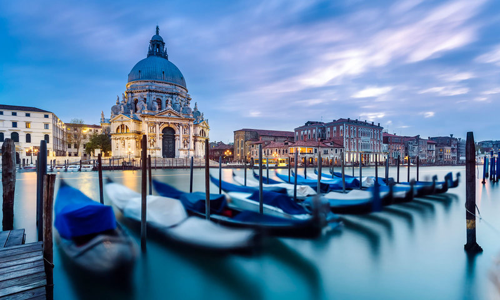

In [ ]:
content_path = '/content/images/content/venice-boat.jpg'
display(Image.open(content_path).resize((500, 300)))

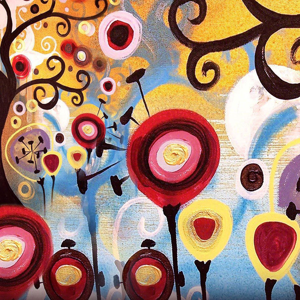

In [ ]:
style_path = '/content/images/9styles/candy.jpg'
display(Image.open(style_path).resize((300, 300)))

In [ ]:
content_image = tensor_load_rgbimage(content_path, size=512,
                                     keep_asp=True).unsqueeze(0)
style = tensor_load_rgbimage(style_path, size=512).unsqueeze(0)
style = preprocess_batch(style)

In [ ]:
style_model = Net(ngf=128)
# model_dict = torch.load('/content/drive/MyDrive/msgnet/models/my.model')
model_dict = torch.load('/content/drive/MyDrive/msgnet/models/Epoch_2iters_24000_Mon_Jan_30_17:47:09_2023_1_5.model', map_location=torch.device('cpu'))
model_dict_clone = model_dict.copy()
for key, value in model_dict_clone.items():
    if key.endswith(('running_mean', 'running_var')):
        del model_dict[key]
style_model.load_state_dict(model_dict, False)

<All keys matched successfully>

In [ ]:
def tensor_save_rgbimage(tensor, filename, cuda=False):
    if cuda:
        img = tensor.clone().cpu().clamp(0, 255).numpy()
    else:
        img = tensor.clone().clamp(0, 255).numpy()
    img = img.transpose(1, 2, 0).astype('uint8')
    img = Image.fromarray(img)
    img.save(filename)

def tensor_save_bgrimage(tensor, filename, cuda=False):
    (b, g, r) = torch.chunk(tensor, 3)
    tensor = torch.cat((r, g, b))
    tensor_save_rgbimage(tensor, filename, cuda)

In [ ]:
style_v = Variable(style)
content_image = Variable(preprocess_batch(content_image))
style_model.setTarget(style_v)
output = style_model(content_image)
tensor_save_bgrimage(output.data[0], 'output.jpg', False)

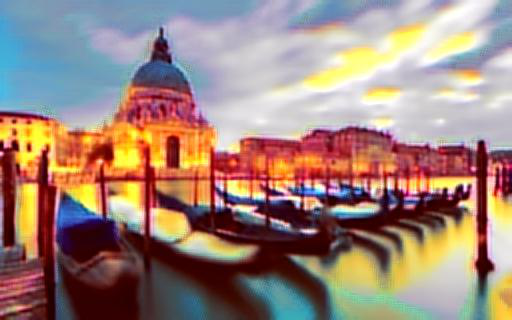

In [ ]:
display(Image.open('output.jpg'))

Result from the original article

    https://github.com/zhanghang1989/PyTorch-Multi-Style-Transfer/blob/master/msgnet.ipynb

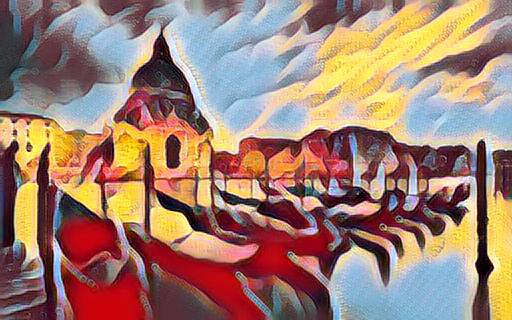

Such a difference might be because I trained my model on a smaller dataset and with only 9 or 21 styles images (against 100 + 900 as in original article - https://arxiv.org/pdf/1703.06953.pdf, https://hangzhang.org/PyTorch-Encoding/tutorials/style.html#train-your-own-msg-net-model). And of course it cannot be ruled out that I made mistakes when adapting the author's code)

In [ ]:
from datetime import datetime

def inference(content_path, style_path):
    display(Image.open(content_path).resize((500, 300)))
    print()
    display(Image.open(style_path).resize((300, 300)))
    print()
    content_image = tensor_load_rgbimage(content_path, size=512,
                                     keep_asp=True).unsqueeze(0)
    style = tensor_load_rgbimage(style_path, size=512).unsqueeze(0)
    style = preprocess_batch(style)
    
    style_v = Variable(style)
    content_image = Variable(preprocess_batch(content_image))
    style_model.setTarget(style_v)
    output = style_model(content_image)
    output_path = f'output + {datetime.now()}.jpg'
    tensor_save_bgrimage(output.data[0], output_path, False)
    display(Image.open(output_path))

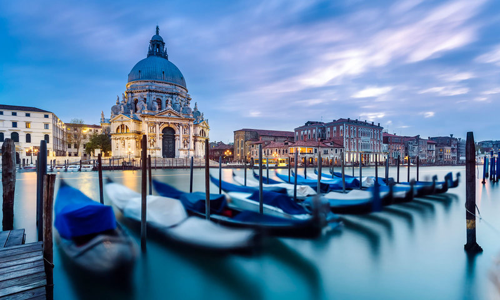

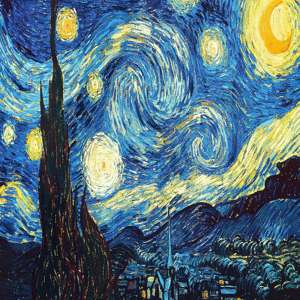

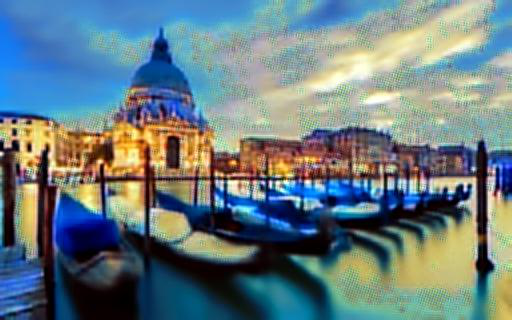

In [ ]:
inference('/content/images/content/venice-boat.jpg', '/content/images/9styles/starry_night.jpg')

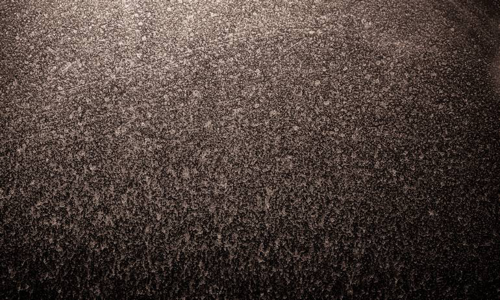

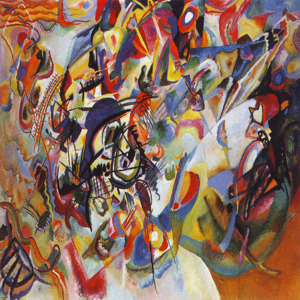

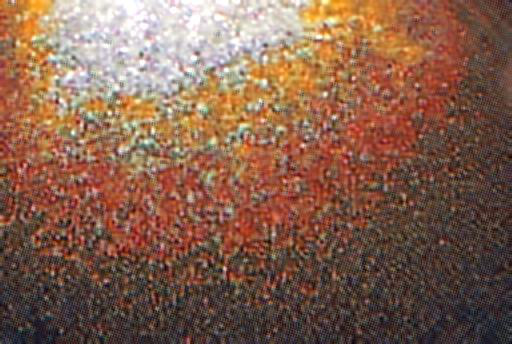

In [ ]:
inference('/content/images/content/noise.jpg', '/content/images/9styles/composition_vii.jpg')

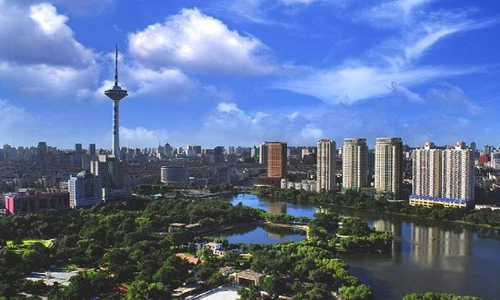

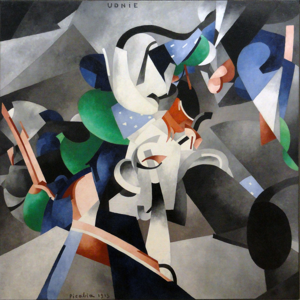

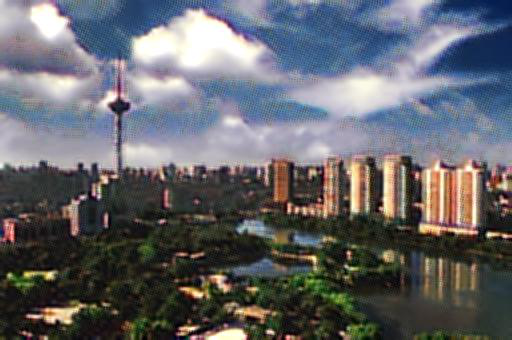

In [ ]:
inference('/content/images/content/shenyang.jpg', '/content/images/9styles/udnie.jpg')

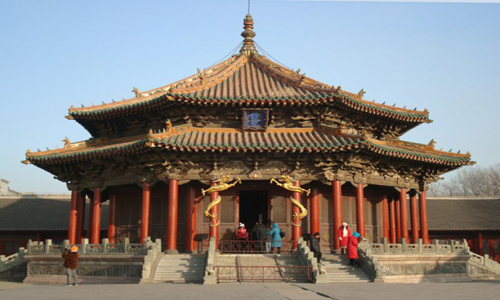

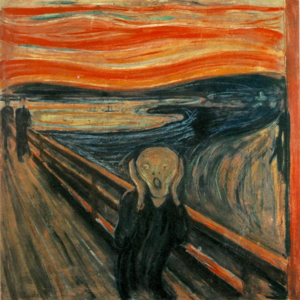

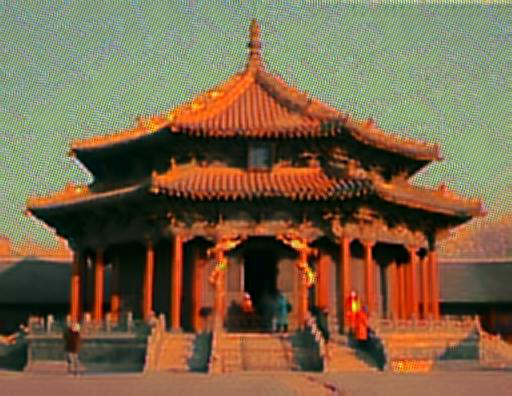

In [ ]:
inference('/content/images/content/shenyang3.jpg', '/content/images/9styles/the_scream.jpg')